In [2]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [3]:
# get link of ads and non ads images
from os import walk
f = []
ctpn_output_path = "../data/dataset/ctpn_output/training_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_path):
    f.append(filenames)
    break
f = f[0]

## 1. Chọn số lượng của bouding box

In [4]:
# Load outpout ctpn and file path
ads_data = []
non_ads_data = []
ads_name = []
non_ads_name = []
for name in f:
    if "ads" == name[:3]:
        ads_data.append([i[:-1] for i in open(ctpn_output_path + name,'r').readlines() if i !="\n"])
        ads_name.append(name)
    else:
        non_ads_data.append([i[:-1] for i in open(ctpn_output_path + name,'r').readlines() if i !="\n"])
        non_ads_name.append(name)
# ads_data = np.array(ads_data)
# non_ads_data = np.array(non_ads_data)


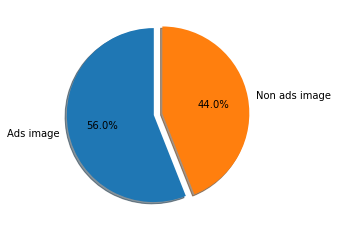

In [5]:
percent_ads = int(len(ads_data)/len(f)*100)
labels = "Ads image","Non ads image"
sizes = [percent_ads, 100 -percent_ads]
explode = [0,0.1]
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels,autopct="%1.1f%%", shadow=True, startangle=90)
plt.show()

In [6]:
# Get size of each ctpn output
len_ads_data = np.array([len(i) for i in ads_data])
len_non_ads_data = np.array([len(i) for i in non_ads_data])
bb_ads = [sum(len_ads_data>i) for i in range(1,40)]
bb_non_ads = [sum(len_non_ads_data>i) for i in range(1,40)]


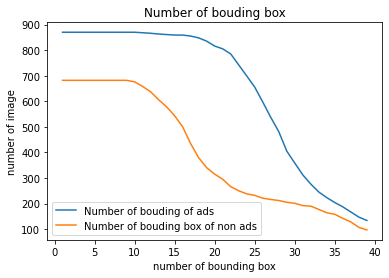

In [17]:
fig, ax = plt.subplots()
ax.plot(range(1,40),bb_ads,label="Number of bouding of ads")
ax.plot(range(1,40),bb_non_ads, label="Number of bouding box of non ads")
ax.set_title("Number of bouding box")
ax.set_xlabel("number of bounding box")
ax.set_ylabel("number of image")
ax.legend()

#### Nhận xét:
- Với tập dữ liệu khoảng 1552 hình ảnh trong đó 870 là hình ảnh có quảng cáo và 682 không có quảng cáo, có thể thấy rằng số lượng hình ảnh có số lượng bouding box giảm mạnh từ 10 trở về sau
- Yêu cầu của bài phân lớp cần phải lấy càng nhiều thông tin về đặc trưng của đối tượng càng nhiều sẽ dễ dàng hơn cho quá trình phân loại ( ngoại trừ các thông tin không cần thiết hoặc nhiễu). Do đó số lượng bouding cần được chọn làm cho mỗi hình ảnh là 10, với bất kì hình ảnh nào nhuều hơn 10 bouding box sẽ phải tiến hành lược bỏ, đối với các hình ảnh có ít hơn 10 bouding box sẽ đcợc gán giá trị trung tính (0.5 True, 0.5 False) những hình này sẽ được đánh giá bởi phase 2

Get height and width of image

In [7]:
img_path = "../data/dataset/training_data"
hw_ads = [PIL.Image.open(img_path + "/" + name[:-3] + "png").size for name in f if 'ads' == name[:3]]
hw_non_ads = [PIL.Image.open(img_path +"/"+ name[:-3] + "png").size for name in f if 'ads' != name[:3]]


Set weight of images

In [8]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [9]:
def sort_weight(bb, temp_scale,temp_distance=None):
    if temp_distance != None:
        temp_scale_sort = sorted(temp_scale)
        temp_distance_sort = sorted(temp_distance)
        bb_t = set()
        for distance in temp_distance_sort[-n_att:]:
            bb_t.add(bb[temp_distance_sort.index(distance)])
        for scale in temp_scale_sort[-n_att:]:
            bb_t.add(bb[temp_scale_sort.index(scale)])
        return list(bb_t),temp_scale_sort[-n_att:] + temp_distance_sort[-n_att:]
    else:
        w = sorted(temp_scale)
        bb_t = []
        for i in range(n_att):
            bb_t.append(bb[temp_scale.index(w[-n_att+i])])
        return bb_t,w[-n_att:]

## 2. Chọn bouding box và chuyển đổi thành giá trị để phân lớp

- Ý tưởng: Dựa trên tỉ lệ của chiều cao chia cho chiều dài và khoảng cách của bouding box so với trung tâm của ảnh chụp trang web
  - Tỉ lệ chiều cao và chiều rộng của bouding box: Những bouding box chứa quảng cáo thường sẽ có chiều cao cao hơn và chiều rộng thấp hơn những bouding box không phải là quảng cáo.
  - Khoảng cách của bouding box so với điểm trung tâm của trang web cũng có ảnh hưởng, những bouding box quảng cáo thông thường sẽ được đặt ở các vị trí trên cùng, bên phải hoặc bên trái của trang web.

- Xây dựng: 
  - Đối với mỗi hình ảnh, gọi chiều cao và chiều rộng của hình ảnh là $H_i$ và $W_i$
  - Gọi:
    - $H_c = H_i/2$ và $W_c = W_i/2$ là vị trí theo chiều cao và chiều rộng của trung tâm hình ảnh
    - $H_b$ và $W_b$ là chiều cao và chiều rộng của bounding box
    - $H_{cb}$ và $W_{cb}$ là vị trí trung tâm của bouding box
  - Tiến hành xây dựng một tập giá trí theo tỉ lệ chiều cao, chiều rộng
    - Gọi $S$ là tập hợp các tỉ lệ của mỗi bouding box được tính bằng $H_b/W_b$
    - Chọn 10 giá trị lớn nhất trong tập $S$ và sắp xếp từ nhỏ tới lớn và lưu ở tập $S_{10}$
  - Tiến hành xây dựng tập hợp giá trị tính theo khoảng cách
    - Gọi $D$ là tập hợp các giá trị của mỗi bouding box được tính bằng $(|H_{cb}-H_c| + 1)(|W_{cb}-W_c|+1)/(H_cW_c)$
    - Vốn dĩ công thức tính cần phải chia cho $H_cW_c$ vì để mang tính công bằng cho công thức tính, tránh những trường hợp các hình ảnh có kích thước khác nhau ảnh hưởng tới khả năng phân lớp
    - Sau đó chọn 10 giá trị lớn nhất của tập $D$ và sắp xếp từ nhỏ tới lớn và lưu ở tập $D_{10}$
  - Kết hợp giữa tỉ lệ và khoảng cách:
    - Xây dựng tập $x$ bằng cách tối tiếp các giá trị của $S_{10}$ và $D_{10}$ lại với nhau
    - Tập hợp $x$ này sẽ là giá trị được dùng để cho quá trình phân lớp

In [131]:
n_att = 10 # lấy 10 bouding box
w_ads = []
# tiến hành chuyển đổi các bouding box của các hình ảnh có quảng cáo 
ads_name_filted =[]
for name,bbs,hw in zip(ads_name,ads_data,hw_ads):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    ads_name_filted.append([name, bb_t])
    w_ads.append(w_t)

In [132]:
w_non_ads = []
non_ads_name_filted = []
# tiến hành chuyển đổi các bouding box của các hình ảnh không có quảng cáo
for name,bbs,hw in zip(non_ads_name,non_ads_data,hw_non_ads):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    non_ads_name_filted.append([name, bb_t])
    w_non_ads.append(w_t)


In [23]:
w_ads[0]

[0.13020833333333334,
 0.13392857142857142,
 0.13541666666666666,
 0.13636363636363635,
 0.14285714285714285,
 0.14583333333333334,
 0.21428571428571427,
 0.22916666666666666,
 0.3333333333333333,
 0.4765625,
 0.2753049045138889,
 0.29778971354166667,
 0.5007172309027778,
 0.5030414496527778,
 0.5459787326388889,
 0.5672005208333334,
 0.6296549479166667,
 0.6372862413194444,
 0.720625,
 0.86923828125]

## 3. Show seleted bounding box
* Green bounding box: discarded bouding box 
* Red bouding box: selected bouding box

In [39]:
import cv2
import matplotlib.pyplot as plt

In [38]:
ctpn_path = "../data/dataset/ctpn_output/testing_data/"
store_path = "./image_bounding_box/"

In [34]:
def resize_image(img):
    img_size = img.shape
    im_size_min = np.min(img_size[0:2])
    im_size_max = np.max(img_size[0:2])

    im_scale = float(600) / float(im_size_min)
    if np.round(im_scale * im_size_max) > 1200:
        im_scale = float(1200) / float(im_size_max)
    new_h = int(img_size[0] * im_scale)
    new_w = int(img_size[1] * im_scale)

    new_h = new_h if new_h // 16 == 0 else (new_h // 16 + 1) * 16
    new_w = new_w if new_w // 16 == 0 else (new_w // 16 + 1) * 16

    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return re_im, (new_h / img_size[0], new_w / img_size[1])
def draw_boudingbox(img,all_bb,red_bb):
    img, (rh, rw) = resize_image(img)
    for bb in all_bb:
        if bb in red_bb:
            bb_list = np.array([int(b) for b in bb.split(",")[:-1]])
            cv2.polylines(img, [bb_list[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 0, 255),
                                  thickness=2)
        else:
            bb_list = np.array([int(b) for b in bb.split(",")[:-1]])
            cv2.polylines(img, [bb_list[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0),thickness=2)
    img = cv2.resize(img, None, None, fx=1.0 / rh, fy=1.0 / rw, interpolation=cv2.INTER_LINEAR)
    return img
def show_image(n_img, img_name):
    for i in range(n_img):
        if "ads" == img_name[i][0][:3]:
            all_bb = ads_data[ads_name.index(img_name[i][0])]
            img = cv2.imread(img_path+"/"+img_name[i][0][:-3] + "png")
        else:
            all_bb = non_ads_data[non_ads_name.index(img_name[i][0])]
            img = cv2.imread(img_path+"/"+img_name[i][0][:-3] + "png")
        img = draw_boudingbox(img,all_bb,img_name[i][1])
        cv2.imwrite(store_path + img_name[i][0][:-3] + "png", img)

In [36]:
show_image(20,ads_name_filted)
show_image(20,non_ads_name_filted)

#### Các hình ảnh bouding box màu đỏ là những bouding box được chọn và màu xanh là không được chọn, sau đây là một vài hình ảnh ví dụ

##### Những hình ảnh chứa quảng cáo

<img src="./image_bounding_box/ads_dantri_106.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/ads_dantri_100.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/ads_dantri_107.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/ads_dantri_118.png" width="50%" style="display:float;float:right">

##### Những hình ảnh không có quảng cáo

<img src="./image_bounding_box/non_ads_dantri_0.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/non_ads_dantri_12.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/non_ads_dantri_102.png" width="50%" style="display:float;float:right">
<img src="./image_bounding_box/non_ads_dantri_104.png" width="50%" style="display:float;float:right">

## 4. Tiến hành huấn luyện

Tạo tập dữ liệu

In [136]:
X = w_ads + w_non_ads
y = [0]*len(w_ads) + [1]*len(w_non_ads)

# Using Neural Netwwork

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [72]:
X_train , X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [73]:
from keras.models import Sequential
from keras.layers import Dense

In [110]:
# define the keras model
model =Sequential()
model.add(Dense(64, input_dim=20, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [111]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
model.fit(X_train,y_train,epochs=100,batch_size=10)

Epoch 1/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9853
Epoch 2/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0347 - accuracy: 0.9871
Epoch 3/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0340 - accuracy: 0.9880
Epoch 4/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0445 - accuracy: 0.9834
Epoch 5/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9880
Epoch 6/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0381 - accuracy: 0.9853
Epoch 7/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0489 - accuracy: 0.9761
Epoch 8/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0442 - accuracy: 0.9834
Epoch 9/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9880
Epoch 10/100
109/109 [==============================] - 0s 1ms/step - loss: 0.0397 - accura

In [137]:
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

In [138]:
metrics.confusion_matrix(y_test,y_pred)

array([[258,  14],
       [ 23, 171]], dtype=int64)

In [139]:
metrics.accuracy_score(y_test, y_pred)

0.9206008583690987

#   Using SVM

In [140]:
from sklearn.svm import SVC

In [141]:
clf = SVC(C=1.0, kernel='rbf', probability=True).fit(X_train,y_train)
clf.probability = True

In [142]:
y_pred = clf.predict(X_test)

In [143]:
metrics.confusion_matrix(y_test,y_pred)

array([[258,  14],
       [ 21, 173]], dtype=int64)

In [144]:
metrics.accuracy_score(y_test,y_pred)

0.924892703862661

## Save SVM support vectors

In [145]:
import joblib

In [146]:
joblib.dump(clf, "svm_phase_1_v2.pkl")

['svm_phase_1_v2.pkl']

## Load SVM by joblid

In [147]:
clf2 = joblib.load("svm_phase_1_v2.pkl")

In [148]:
r = clf2.predict(X_test)

In [149]:
metrics.confusion_matrix(y_test, r)

array([[258,  14],
       [ 21, 173]], dtype=int64)